# 15-688 Final Project on Analytics & Predictions for Wind Farm Power Output

#### Project by: Ishan Saraswat (AndrewID: isaraswa)
## Introduction

This project is based on data analysis to gain insights and power output prediction for the 'La-Haute-Borne' Wind Farm based in the commune of Vaudeville-le-Haute in north-eastern France. 

## Project contents

- [Motivation: Renewable Energy Sources and the Grid](#Motivation:-Renewable-Energy-Sources-and-the-Grid)
- [Wind Power Forecasting](#Wind-Power-Forecasting)
- [Extracting the data](#Extracting-the-data)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Predicting the Power Output](#Predicting-the-Power-Output)
- [Future Work and Resources](#Future-Work-and-Resources)

## Motivation: Renewable Energy Sources and the Grid

In order to meet our climate goals, it is essential that we move towards a decarbonised energy sector. Coal and nuclear power plants provide what is called baseload power. What this means is these power plants are capable of producing a steady and predictable power output continuously. Since the electricity demand is not always constant, we need other sources of power which can be ramped up and down based on the demand. The following figure illustrates the nature of dispatchable power in terms of baseload, loadfollowing and peaking power. 
   
[<img src="http://www.energypost.eu/wp-content/uploads/2016/03/Diesendorf-figure-1-electriity-demand-with-baseload.png" width="500">](http://www.energypost.eu/wp-content/uploads/2016/03/Diesendorf-figure-1-electriity-demand-with-baseload.png)

### Challenge in integrating renewable sources into the electric grid
The power output from renewable sources such as wind and solar is highly variable and unpredictable. We are in a way at the behest of nature when it comes to how much power we can generate from these sources at any given point of time. The following figure shows 5 minute wind power output for a week from Bonneville Power Authority with nameplate capacity 3788 MW and 1 second wind power output for 10 days from a wind farm in Mid Atlantic United States
   
[<img src="https://static.seekingalpha.com/uploads/2016/9/34605935_14750728033629_rId17.png" width="700" height="700">](https://static.seekingalpha.com/uploads/2016/9/34605935_14750728033629_rId17.png)

Grid operators must at all times balance the electricity generation and demand on the grid. This is accomplished by using load-following and peaking power plants to follow the demand as shown in the figure above. However, when a solar or wind plant has to be integrated into the grid, its uncertain power generation must be taken into account and as higher and higher percentage of renewable sources are integrated this uncertainty increases. Thus some amount of reserve capacity in the form of high ramping power plants such as gas peaker plants must be kept on standby to meet the demand 
   
Hence it is essential to have a forecast of the demand as well as the supply from these renewable sources. This can help better manage the integration of these renewable sources into the grid as it allows the grid operators to efficiently allocate generation in the day ahead electricity markets, have a more economically efficient stock of reserve capacity, manage grid frequency fluctuations and reduce system level costs for the electricity produced from the renewable sources. The following figure shows additional day-ahead reserve capacity for maximum wind forecast uncertainty for a range of wind penetration values for ERCOT (Texas) and MISO (MidWest USA) grid regions.(Mauch et al.)

[<img src="https://s3-eu-west-1.amazonaws.com/ppreviews-iop-487454658/1479339/preview.jpg" width="400">](https://s3-eu-west-1.amazonaws.com/ppreviews-iop-487454658/1479339/preview.jpg)

# Wind Power Forecasting

   Wind power forecasting refers to predicting the power output of one or more turbines in the near future (with units of kW or normalized with respect to the wind farm capcity). 
   
### Time scales of forecast

   The forecasting of wind power generation may be considered at different time scales, depending on what the intended application of the forecast is. *Very-short term* forecasts may be done on the scale of a few minutes to a few hours. This is mainly used for turbine active control and ancillary services management on the grid such as frequency regulation. *Short-term forecasts* may be done on the scale of 48 to 72 hours. These forecasts are mainly used for energy trading on the day-ahead markets, reserve capacity planning, optimal scheduling of generators (Unit Commitment) and their economic dispatch. *Long-term forecasts* on the scale of up to a week to 10 days ahead may be considered for planning optimal maintainence on the wind turbines. Maintainence of offshore wind turbines is especially costly so optimal planning of operations is important
   
### Different approaches to wind power forecasting   
 - Physical Approach: 
It focuses on the description of the wind flow around and inside the wind farm, in addition to using the manufacturer’s power curve in order to propose an estimation of the wind power output.
 - Statistical Approach:
It consists of emulating the relation between meteorological predictions, historical measurements and generation output through statistical models whose parameters have to be estimated from data, without taking any physical phenomena into account.


# Extracting the data
We will collect wind farm data provided by the French electric utility company ENGIE. It is very hard to find power plant level production data for a wind plant since plant operators do not usually disclose this information as it si of importance to the energy markets. ENGIE has established what they call the first open data wind farm located in north-easter France near the commune of Vaudeville-le-Haute called the 'La-Haute-Borne' wind farm. It has hosted the data for this wind farm on the website: [ENGIE wind farm data](https://opendata-renewables.engie.com/pages/home/)

[<img src="https://image.ibb.co/mrzYFd/Picture1.png" width="600">](https://image.ibb.co/mrzYFd/Picture1.png)

The site uses a public web api which allows anyone to interface with the website and extract the relevant data. The site contains good documentation of how to utilize the api to exctract data. [Documentation](https://opendata-renewables.engie.com/api/v1/documentation) We will utilize the 'La Haute Borne Data (2013-2016)' dataset which consists of power output and meteorological parameters measured at the wind farm for all four wind turbines for a period of 2013-2016. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#import io, time, json
import requests
#import IPython.display as display

The api has a search command which can be used to explore and download the datasets. However as we can see on the website this dataset contains more than 800,000 records over the four years 2013-16. While the search command has a limit of returning 10,000 records at a time. However, the api specifies that for an unlimited records search we can use the download query instead of search: <br>
`Download`: /api/records/1.0/download/ <br>
`Description`:This API provides Records download streaming features. It accepts the same filtering parameters as the Search API but returns a flow of Records as they are generated by the server.
We will use the requests library to request the api and parse the stream of text returned by the query using string formatting.

In [3]:
url = "https://opendata-renewables.engie.com/api/records/1.0/download/?dataset=la-haute-borne-data-2013-2016&rows=-1&facet=wind_turbine_name&facet=date_time"

In [4]:
response = requests.get(url)

In [22]:
text = response.text

In [26]:
text = text.split('\r\n')

In [27]:
len(text)

840382

After splitting each record spearated by '\r\n' in the returned text string we will load each record as a row in a pandas dataframe

In [331]:
text[0:2]

['R80711;2013-01-06T10:20:00+00:00;-0.75999999;-1.0;0.0;0.40000001;13.78;13.0;14.0;0.34999999;1041.27;960.59998;1157.36;64.559998;1052.1;249.23;1557.42;374.07001;87.900002;0.77999997;159.72;46.110001;75.080002;21.92;109.34;32.619999;124.47;39.889999;183.75;32.650002;0.76999998;1.0;0.029999999;0.28;1039.77;959.04999;1155.9399;64.589996;44.32;43.599998;44.849998;0.23999999;43.43;43.0;43.799999;0.18000001;64.919998;63.400002;66.0;0.47999999;56.849998;56.25;57.450001;0.31;55.709999;54.849998;56.5;0.44999999;49.860001;49.25;50.450001;0.23;50.950001;50.400002;51.200001;0.090000004;278.87;278.87;278.87;0.0;22.59;17.700001;25.299999;2.9200001;4.6599998;2.6600001;6.4699998;0.68000001;4.8600001;3.01;6.5500002;0.69999999;4.7600002;2.8399999;6.4699998;0.67000002;278.01001;205.60001;336.29999;16.93;;;;;;;;;-0.86000001;-73.269997;57.419998;16.93;6.5700002;6.5;6.6999998;0.090000004;49.98;49.959999;50.009998;0.0099999998;700.78003;699.06;702.03003;0.66000003;9.8999996;9.1099997;11.01;0.62;23.700001;23

In [31]:
columns = text[0]
columns = columns.split(';')
del text[0]
del text[-1]

In [37]:
len(text)

840380

In [38]:
df = pd.DataFrame(columns=columns)
df

,wind_turbine_name,date_time,ba_avg,ba_min,ba_max,ba_std,rt_avg,rt_min,rt_max,rt_std,...,pas_max,pas_std,wa_c_avg,wa_c_min,wa_c_max,wa_c_std,na_c_avg,na_c_min,na_c_max,na_c_std


In [39]:
list_dict = []
cols = columns
for row in text:
    entry = row.split(';')
    list_dict.append(dict(zip(cols, entry)))

In [40]:
len(list_dict)

840380

In [43]:
df = df.append(list_dict)

In [50]:
df.head()

,wind_turbine_name,date_time,ba_avg,ba_min,ba_max,ba_std,rt_avg,rt_min,rt_max,rt_std,...,pas_max,pas_std,wa_c_avg,wa_c_min,wa_c_max,wa_c_std,na_c_avg,na_c_min,na_c_max,na_c_std
0,R80711,2013-01-06T10:20:00+00:00,-0.75999999,-1.0,0.0,0.40000001,13.78,13.0,14.0,0.34999999,...,,,293.01001,,,,293.87,,,
1,R80711,2013-01-06T06:30:00+00:00,-0.38999999,-1.0,0.07,0.34999999,13.0,13.0,13.0,0.0,...,,,263.41998,,,,223.98,,,
2,R80711,2013-01-06T13:00:00+00:00,-0.94999999,-1.0,0.0,0.17,14.0,14.0,14.0,0.0,...,,,305.81,,,,293.87,,,
3,R80711,2013-01-06T08:50:00+00:00,-1.0,-1.0,-1.0,0.0,13.15,13.0,14.0,0.27000001,...,,,285.79999,,,,293.87,,,
4,R80711,2013-01-10T16:30:00+00:00,-1.0,-1.0,-1.0,0.0,9.5600004,9.0,10.0,0.41999999,...,,,201.86,,,,207.17,,,


As we can see the dataframe contains 840380 records and 138 columns

In [51]:
df.shape

(840380, 138)

In [53]:
df.columns.values

array(['wind_turbine_name', 'date_time', 'ba_avg', 'ba_min', 'ba_max',
       'ba_std', 'rt_avg', 'rt_min', 'rt_max', 'rt_std', 'dcs_avg',
       'dcs_min', 'dcs_max', 'dcs_std', 'cm_avg', 'cm_min', 'cm_max',
       'cm_std', 'p_avg', 'p_min', 'p_max', 'p_std', 'q_avg', 'q_min',
       'q_max', 'q_std', 's_avg', 's_min', 's_max', 's_std', 'cosphi_avg',
       'cosphi_min', 'cosphi_max', 'cosphi_std', 'ds_avg', 'ds_min',
       'ds_max', 'ds_std', 'db1t_avg', 'db1t_min', 'db1t_max', 'db1t_std',
       'db2t_avg', 'db2t_min', 'db2t_max', 'db2t_std', 'dst_avg',
       'dst_min', 'dst_max', 'dst_std', 'gb1t_avg', 'gb1t_min', 'gb1t_max',
       'gb1t_std', 'gb2t_avg', 'gb2t_min', 'gb2t_max', 'gb2t_std',
       'git_avg', 'git_min', 'git_max', 'git_std', 'gost_avg', 'gost_min',
       'gost_max', 'gost_std', 'ya_avg', 'ya_min', 'ya_max', 'ya_std',
       'yt_avg', 'yt_min', 'yt_max', 'yt_std', 'ws1_avg', 'ws1_min',
       'ws1_max', 'ws1_std', 'ws2_avg', 'ws2_min', 'ws2_max', 'ws2_std',
    

The website also provides two csv files called data_description and static-information which contain detailed information about the data features included in the dataset and some important metadata for the turbines themselves such as Manufacturer, model, hub height, rated power, geolocation etc.

In [57]:
descript = pd.read_csv('data_description.csv', sep=';')
descript

,Variable_name,Variable_long_name,Unit_long_name,Comment
0,Va2,Vane_position_2,deg,Second wind vane on the nacelle
1,Ws2,Wind_speed_2,m/s,Second anemometer on the nacelle
2,Ws,Wind_speed,m/s,Average wind speed
3,Wa_c,Absolute_wind_direction_corrected,deg,NaN
4,Na_c,Nacelle_angle_corrected,deg,NaN
5,Ot,Outdoor_temperature,deg_C,NaN
6,Yt,Nacelle_temperature,deg_C,NaN
7,Nf,Grid_frequency,Hz,NaN
8,Nu,Grid_voltage,V,NaN
9,Rm,Torque,Nm,NaN


In [58]:
stat = pd.read_csv('static-information.csv', sep=';')
stat

,Wind_turbine_name,Wind_turbine_long_name,Manufacturer,Model,Rated power (kW),Hub height (m),Rotor diameter (m),GPS,Altitude (m),Commissioning date,Department,Region
0,R80736,FRHBO_E04_80736,Senvion,MM82,2050,80,82,"48.4461, 5.5925",411,2009-01-15,Meuse,Grand Est
1,R80711,FRHBO_E01_80711,Senvion,MM82,2050,80,82,"48.4569, 5.5847",411,2009-01-15,Meuse,Grand Est
2,R80790,FRHBO_E02_80790,Senvion,MM82,2050,80,82,"48.4536, 5.5875",411,2009-01-15,Meuse,Grand Est
3,R80721,FRHBO_E03_80721,Senvion,MM82,2050,80,82,"48.4497, 5.5869",411,2009-01-15,Meuse,Grand Est


In [54]:
df.loc[1:10,['wa_c_avg', 'wa_avg', 'ot_avg', 'yt_avg', 'rt_avg']]

,wa_c_avg,wa_avg,ot_avg,yt_avg,rt_avg
1,263.41998,248.42,5.6199999,21.549999,13.0
2,305.81,290.81,6.5300002,19.25,14.0
3,285.79999,270.79999,6.1999998,24.77,13.15
4,201.86,186.86,3.5,19.700001,9.5600004
5,22.01,7.0100002,-3.01,11.42,6.0
6,37.77,22.77,5.25,20.57,12.65
7,285.53,270.53,6.4000001,22.1,13.0
8,302.87,287.87,5.5100002,23.299999,13.0
9,343.69,328.69,4.4499998,18.809999,10.01
10,313.35001,298.35001,4.77,20.610001,12.95


We can confirm that the dataset contains data for all 4 turbines in the wind farm by using the `pandas.Series.unique()` call

In [56]:
df.wind_turbine_name.unique()

array(['R80711', 'R80736', 'R80790', 'R80721'], dtype=object)

We will choose to keep only the following columns in the dataframe: Date_time, Average Power, Average Wind Speed, Corrected average wind direction, and outdoor temperature. We will also split the dataset into the four turbines and construct a separate dataframe for each using a dictionary called `turbines`

In [97]:
# Defining the columns to keep
cols_2_keep = ['Date_time', 'P_avg', 'Ws_avg', 'Wa_c_avg', 'Ot_avg']

# process the data
turbines = {}
index = 1
for name in df.Wind_turbine_name.unique():
    # Splitting data based on wind turbine (1-4)
    turbine_name = 'turbine_{}'.format(index)
    turbine_data = df.loc[df['Wind_turbine_name'] == name]
    
    # Cleaning each turbine data by removing Nan's in the wind speed column
    turbine_data_clean = turbine_data[np.isfinite(turbine_data['Ws_avg'])]
    turbines[turbine_name] = turbine_data_clean.loc[:, cols_2_keep]
    index += 1

In [98]:
turbines['turbine_1'].head()

,Date_time,P_avg,Ws_avg,Wa_c_avg,Ot_avg
0,2013-01-06T05:20:00-05:00,87.900002,4.76,293.01001,6.57
1,2013-01-06T01:30:00-05:00,35.970001,4.29,263.41998,5.62
2,2013-01-06T08:00:00-05:00,108.670000,4.96,305.81000,6.53
3,2013-01-06T03:50:00-05:00,182.300000,5.28,285.79999,6.20
4,2013-01-10T11:30:00-05:00,454.200010,6.60,201.86000,3.50


We will convert the data_time object in the datafram into a pandas `datetime` object to better manipulate the time related features in the dataset. We will add a day of year feautre from the datetime values and sort the data based on the timestamp it was collected

In [100]:
# Converting date_time column to datetime variable and picking out day,month,hour,minute and year
for key in turbines.keys():
    turbines[key]['Date_time'] = pd.to_datetime(turbines[key]['Date_time'],format = '%Y-%m-%dT%H:%M:%S')
    turbines[key]['Day'] = turbines[key]['Date_time'].dt.day;
    turbines[key]['Month'] = turbines[key]['Date_time'].dt.month;
    turbines[key]['Hour'] = turbines[key]['Date_time'].dt.hour;
    turbines[key]['Minute'] = turbines[key]['Date_time'].dt.minute;
    turbines[key]['Year'] = turbines[key]['Date_time'].dt.year;
    turbines[key]['DOY'] = turbines[key]['Date_time'].dt.dayofyear

In [103]:
# Sorting the rows based on the date time
for key in turbines.keys():
    turbine_sorted = turbines[key].sort_values(by = 'Date_time')
    turbines[key] = turbine_sorted.set_index('Date_time')

In [105]:
turbines['turbine_1'].tail()

,P_avg,Ws_avg,Wa_c_avg,Ot_avg,Day,Month,Hour,Minute,Year,DOY
Date_time,,,,,,,,,,
2016-12-31 22:10:00,-0.560000,3.30,195.14000,3.83,31,12,22,10,2016,366
2016-12-31 22:20:00,-0.730000,3.46,196.17999,3.66,31,12,22,20,2016,366
2016-12-31 22:30:00,20.950001,3.87,195.72000,3.52,31,12,22,30,2016,366
2016-12-31 22:40:00,54.900002,4.37,196.32001,3.62,31,12,22,40,2016,366
2016-12-31 22:50:00,94.010002,4.80,198.25000,3.73,31,12,22,50,2016,366


##### Feature Engineering: Cyclical Time Features 
We will cinstruct a sine and cosine transform to encode the cyclical information about the day of the year and the hour of the day when the data was collected. We will also clean the dataset by removing nan values and finding the intersection of hte timestamps in all four turbines so they contain data for the same date and times and the same number of records.  

In [118]:
for key in turbines.keys():
    turbines[key] = turbines[key].assign(cos_hr = lambda x: np.cos(x['Hour']*2*np.pi/24))
    turbines[key] = turbines[key].assign(sin_hr = lambda x: np.sin(x['Hour']*2*np.pi/24))
    turbines[key] = turbines[key].assign(cos_day = lambda x: np.cos(x['DOY']*2*np.pi/365))
    turbines[key] = turbines[key].assign(sin_day = lambda x: np.sin(x['DOY']*2*np.pi/365))

In [124]:
turbines['turbine_1'].head()

,P_avg,Ws_avg,Wa_c_avg,Ot_avg,Day,Month,Hour,Minute,Year,DOY,cos_hr,sin_hr,cos_day,sin_day
Date_time,,,,,,,,,,,,,,
2012-12-31 23:00:00,1072.6500,8.960000,180.25000,5.09,31,12,23,0,2012,366,0.965926,-0.258819,0.999852,0.017213
2012-12-31 23:10:00,1061.4301,8.890000,183.28999,5.26,31,12,23,10,2012,366,0.965926,-0.258819,0.999852,0.017213
2012-12-31 23:20:00,1144.7900,9.190000,185.08000,5.56,31,12,23,20,2012,366,0.965926,-0.258819,0.999852,0.017213
2012-12-31 23:30:00,1183.9800,8.920000,190.33000,5.70,31,12,23,30,2012,366,0.965926,-0.258819,0.999852,0.017213
2012-12-31 23:40:00,1317.5500,9.479999,188.07001,5.82,31,12,23,40,2012,366,0.965926,-0.258819,0.999852,0.017213


In [125]:
# use the intersection of time of all 4 turbines and keep the common times
idx = turbines['turbine_1'].index.intersection(turbines['turbine_2'].index)
idx2 = turbines['turbine_3'].index.intersection(idx)
idx3 = turbines['turbine_4'].index.intersection(idx2)

for key in turbines.keys():
    turbines[key] = turbines[key].loc[idx3]
    
print (len(turbines['turbine_1']))
print (len(turbines['turbine_2']))
print (len(turbines['turbine_3']))
print (len(turbines['turbine_4']))
turbines['turbine_1'].head()

207789
207789
207789
207789


,P_avg,Ws_avg,Wa_c_avg,Ot_avg,Day,Month,Hour,Minute,Year,DOY,cos_hr,sin_hr,cos_day,sin_day
Date_time,,,,,,,,,,,,,,
2012-12-31 23:00:00,1072.6500,8.960000,180.25000,5.09,31,12,23,0,2012,366,0.965926,-0.258819,0.999852,0.017213
2012-12-31 23:10:00,1061.4301,8.890000,183.28999,5.26,31,12,23,10,2012,366,0.965926,-0.258819,0.999852,0.017213
2012-12-31 23:20:00,1144.7900,9.190000,185.08000,5.56,31,12,23,20,2012,366,0.965926,-0.258819,0.999852,0.017213
2012-12-31 23:30:00,1183.9800,8.920000,190.33000,5.70,31,12,23,30,2012,366,0.965926,-0.258819,0.999852,0.017213
2012-12-31 23:40:00,1317.5500,9.479999,188.07001,5.82,31,12,23,40,2012,366,0.965926,-0.258819,0.999852,0.017213


In [126]:
df1 = turbines['turbine_1'].copy()
df2 = turbines['turbine_2'].copy()
df3 = turbines['turbine_3'].copy()
df4 = turbines['turbine_4'].copy()

In [127]:
df1.dropna(inplace=True)
df2.dropna(inplace=True)
df3.dropna(inplace=True)
df4.dropna(inplace=True)

In [128]:
print(len(df1))
print(len(df2))
print(len(df3))
print(len(df4))

200329
200329
200329
200329


# Exploratory Data Analysis
### Plotting power curves

We will construct empirical power curves for all four turbines which models the behaviour of the turbine based on the wind speed. This is useful to analyze the power output of the turbine and has value over the provided manufacturers power curve as this is based on observational data while the turbine was in operation. We will plot the normalized power output of the turbine against the wind speed to do this. 

Text(0.5,1,'Empirical Power Curve for Turbine 4')

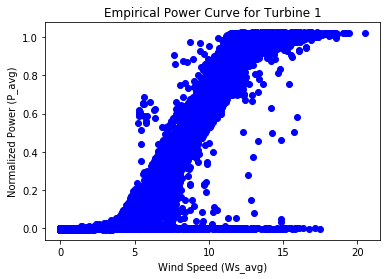

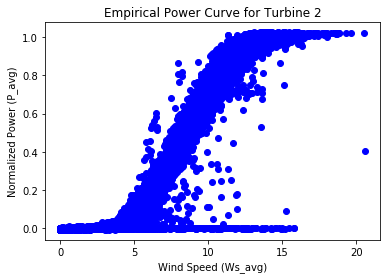

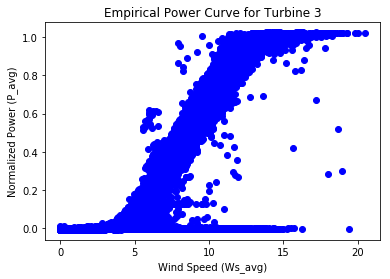

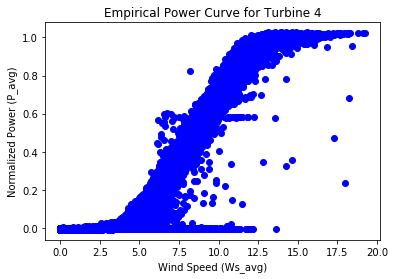

In [129]:
# Turbine 1
plt.figure(1)
plt.plot(df1.Ws_avg, df1.P_avg/2000,'bo')
plt.xlabel('Wind Speed (Ws_avg)')
plt.ylabel('Normalized Power (P_avg)')
plt.title('Empirical Power Curve for Turbine 1')

# Turbine 2
plt.figure(2)
plt.plot(df2.Ws_avg, df2.P_avg/2000,'bo')
plt.xlabel('Wind Speed (Ws_avg)')
plt.ylabel('Normalized Power (P_avg)')
plt.title('Empirical Power Curve for Turbine 2')

# Turbine 3
plt.figure(3)
plt.plot(df3.Ws_avg, df3.P_avg/2000,'bo')
plt.xlabel('Wind Speed (Ws_avg)')
plt.ylabel('Normalized Power (P_avg)')
plt.title('Empirical Power Curve for Turbine 3')

# Turbine 4
plt.figure(4)
plt.plot(df4.Ws_avg, df4.P_avg/2000,'bo')
plt.xlabel('Wind Speed (Ws_avg)')
plt.ylabel('Normalized Power (P_avg)')
plt.title('Empirical Power Curve for Turbine 4')

Some interesting observations can be made from the power curves. The shape of all the curves is inherent to the nature of wind turbines, The lower part where the curve starts increasing denotes the cut in wind speed or the minimum wind speed required for this turbine to generate power. The outliers to the right where the wind speed is significantly more than the cut in speed but there is 0 power production might indicate periods when the turbine was under maintainenece. All the curves stop abruptly at much higher wind speeds when they are producing power at the max capacity. This is known as wind cut out speed and it is the wind speed at which the wind blades are brought to rest in order to avoid damage. 

### Wind farm capacity factor

The capacity factor of a power plant is the total amount of power generated over the maximum rater capacity in a given period of time. As stated in the introduction baseload power plants operate near their maximum for most of the time and thus have very high capacity factors (commonly, coal: 60% nuclear: 85-90%). Whereas wind plants usually have a much smaller capacity factor since the wind does not blow all the time. Usual capacity factors for wind plants are 15-25% although some newer plants in the US operate at upto 40-45%

In [146]:
total_power = sum(turbines['turbine_1'].P_avg+turbines['turbine_2'].P_avg+turbines['turbine_3'].P_avg+turbines['turbine_4'].P_avg)/8000
capacity_factor = total_power/200329
print('Capacity Factor for the Wind Farm throughout the period of this data is {}'.format(round(capacity_factor, 2)))

Capacity Factor for the Wind Farm throughout the period of this data is 0.17


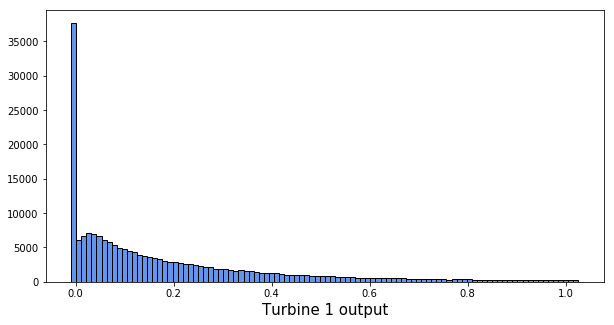

In [136]:
# Plot histogram of turbine output, summed over all turbines
fig, axes = plt.subplots( nrows=1, ncols=1, figsize=(10,5) )
axes.hist(df1['P_avg']/2000, bins=100, range=None, normed=False, histtype='bar', align='mid', 
          orientation='vertical', log=False, color='cornflowerblue', edgecolor='k', label=None)
axes.set_xlabel("Turbine 1 output", fontsize=15)
plt.show()
fig.savefig('wind_turbine1_outputs.png', dpi=200, bbox_inches='tight')

The histogram for the turbine 1 output shows that the wind turbine produces significantly less power than its capacity for most of the time.

In [147]:
cf1 = round(sum(df1['P_avg']/2000)/len(df1), 2)
cf2 = round(sum(df2['P_avg']/2000)/len(df2), 2)
cf3 = round(sum(df3['P_avg']/2000)/len(df3), 2)
cf4 = round(sum(df4['P_avg']/2000)/len(df4), 2)

In [148]:
print('The Capacity Factors for the individual turbines are : \nTurbine 1: {0}\nTurbine 2: {1}\nTurbine 3: {2}\nTurbine 4: {3}'.format(cf1,cf2,cf3,cf4))

The Capacity Factors for the individual turbines are : 
Turbine 1: 0.19
Turbine 2: 0.17
Turbine 3: 0.15
Turbine 4: 0.16


### Wind power output as a function of wind speed
Lets analyze the effect of the wind speed on the power output by visualizing the power output of turbine 1 and wind speed measured at this turbine

In [155]:
maxwind = df1.loc[df1['Ws_avg'].idxmax(), 'Ws_avg']
maxpower = df1.loc[df1['P_avg'].idxmax(), 'P_avg']
print(maxwind, maxpower)

20.48 2051.3799


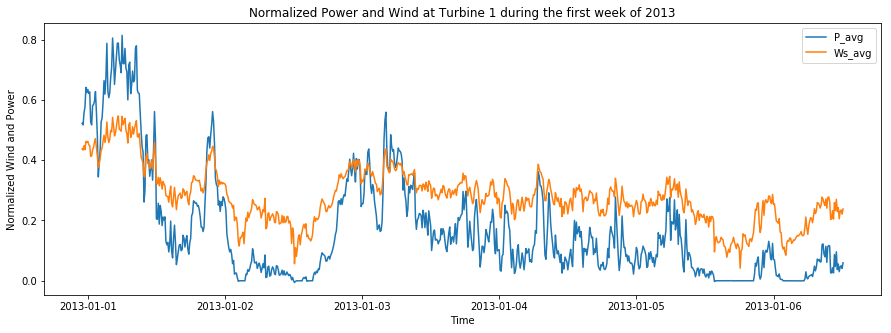

In [157]:
plt.figure(figsize=(15,5))
plt.plot(df1['P_avg'][:800]/maxpower)
plt.plot(df1['Ws_avg'][:800]/maxwind)
plt.xlabel('Time')
plt.ylabel('Normalized Wind and Power')
plt.title('Normalized Power and Wind at Turbine 1 during the first week of 2013')
plt.legend(loc='upper right')

As we can see, the power output closely follows the pattern of the wind speed at the turbine. An interesting observation is that on the 6th of Janurary, the wind was low enough that it did not cross the turbines cut in speed and hence power output was zero.

### Wind Spectral Density
The Power spectral density function (PSD) shows the strength of the variations in power output of the wind plant as a function of frequency. In other words, it shows at which frequencies variations are strong and at which frequencies variations are weak. This is extremely important as it reveals a critical characteristic of wind power output. 

In [321]:
from scipy import signal as signal
import matplotlib.pyplot as plt

In [325]:
fs = 10e3
x = df1['P_avg']
f, Pxx_den = signal.periodogram(x, fs)

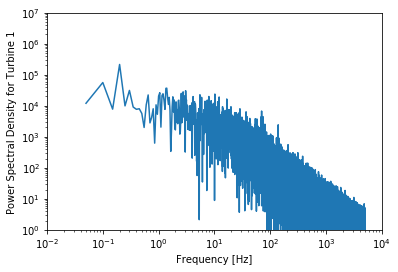

In [334]:
plt.loglog(f, Pxx_den)
plt.ylim([1, 1e7])
plt.xlim([1e-2, 1e4])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density for Turbine 1')
plt.show()

As we can see in the PSD curve, the amplitude of variations in the power output for turbine 1 are many orders of magnitude higher at the lower frequencies than at the higher frequencies. This implies that the power fluctuations at the seconds to minutes time scale are much weaker than the variations in power output at the hours to days time scale. This allows us to use fairly moderate ramping plants such as coal and natural gas plants to fill in for the variations. 

### Wind Rose Diagram
To analyze the the behaviour of wind at the site we can look at the wind rose diagram by plotting the wind speed and direction in the form of a wind rose plot for the year 2016

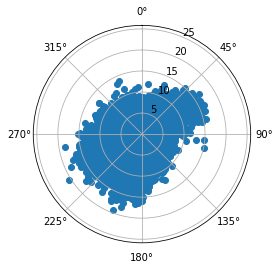

In [354]:
from math import radians
import matplotlib.cm as cm
from math import pi

ax = plt.subplot(111, polar=True)
ax.scatter(x=[radians(x) for x in df1.loc['2016-01-01':'2016-12-31']['Wa_c_avg'].values], y=df1.loc['2016-01-01':'2016-12-31']['Ws_avg'].values)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

# Predicting the Power Output
### Random Forest Regression

The Random Forest is one of the most effective machine learning models for predictive analytics, making it an industrial workhorse for machine learning.

Background
The random forest model is a type of additive model that makes predictions by combining decisions from a sequence of base models. More formally we can write this class of models as:

    g(x)=f0(x)+f1(x)+f2(x)+...

where the final model g is the sum of simple base models fi. Here, each base regressor is a simple decision tree. This broad technique of using multiple models to obtain better predictive performance is called model ensembling. In random forests, all the base models are constructed independently using a different subsample of the data. We will use the `scikit-learn` library to implement the Random Forest Regression algorithm to predict the wind power output of turbine 1 based on the historial wind speed and other metereological data collected at the wind farm and make predictions on the 72 hour ahead time scale based on wind speed. This allows us to build a statistical model of the behaviour (power output) of the wind turbine based on learnt model.

Different kinds of models have different advantages. The random forest model is very good at handling tabular data with numerical features, or categorical features with fewer than hundreds of categories. Unlike linear models, random forests are able to capture non-linear interaction between the features and the target.

In [172]:
from sklearn.ensemble import RandomForestRegressor
#from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [279]:
#model = RandomForestRegressor(n_jobs=-1, min_impurity_decrease=10)
model = RandomForestRegressor(n_estimators=10, n_jobs=-1)

#### Create training and test sets
We split the intire dataset for turbine 1 which covers data fro 2013-2016 into training and testing sets. We utilize approximately 75% of the data for training and the rest for making predictions. We choose the following features for the model: Average wind speed, Corrected wind direction, Outdoor temperature, Sine and cosine transformations of calendar inputs and an auto regressive feature based on the previously observed wind speed to incorporate the effects of the wind speed time series data. 

In [280]:
X = df1[['Ws_avg', 'Wa_c_avg', 'Ot_avg', 'cos_hr', 'sin_hr', 'cos_day', 'sin_day']].values
Y = df1['P_avg'].values

In [281]:
X1 = df1[['Ws_avg']].values
X1 = X1[1:]
X = X[0:200328, :]
X1 = X1.flatten()

In [282]:
Y = Y[0:200328]

In [283]:
Y.shape

(200328,)

In [284]:
X = np.column_stack([X, X1.tolist()])

In [285]:
X.shape

(200328, 8)

In [304]:
labels = ['Ws_avg', 'Wa_c_avg', 'Ot_avg', 'cos_hr', 'sin_hr', 'cos_day', 'sin_day', 'Ws_avg_lag']; labels

['Ws_avg',
 'Wa_c_avg',
 'Ot_avg',
 'cos_hr',
 'sin_hr',
 'cos_day',
 'sin_day',
 'Ws_avg_lag']

In [287]:
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
X_train = X[:150000]
y_train = Y[:150000]
X_test = X[150000:]
y_test = Y[150000:]

#### Transform the data
We centre the data around a mean of zero and variance of one.

In [288]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

We try different number of estimators by recursively training the model with an increasing number of trees used in the learning and plotting the performance of the model based on coefficient of determination R^2 of the prediction.

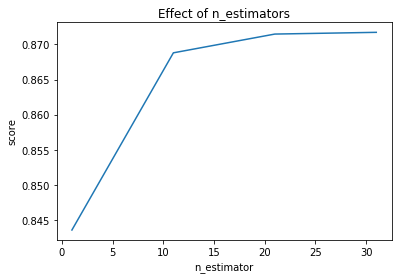

In [289]:
# Try different numbers of n_estimators or trees - this will take a minute or so
estimators = np.arange(1, 33, 10)
scores = []
for n in estimators:
    model.set_params(n_estimators=n)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

We predict the power output on our test data based on the learned model

In [290]:
y_predicted = model.predict(X_test)

#### Feature Importance
We look at which features are the most important for our dataset

In [305]:
result = pd.DataFrame()
result['feature'] = labels
result['importance'] = model.feature_importances_
result.sort_values(by=['importance'], ascending=False, inplace=True)
result

,feature,importance
0,Ws_avg,0.953740
5,cos_day,0.014581
2,Ot_avg,0.008632
6,sin_day,0.008577
1,Wa_c_avg,0.007412
7,Ws_avg_lag,0.003193
3,cos_hr,0.002028
4,sin_hr,0.001836


In [309]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [307]:
score = r2_score(y_test, y_predicted)
score

0.87171488320633395

Our model scores an accuracy score of 87% based on the coefficient of determination R^2 of the prediction.
Let us plot the 72 hour ahead forecast based on our predictions on the test dataset for the power output of turbine 1

Text(0.5,1,'')

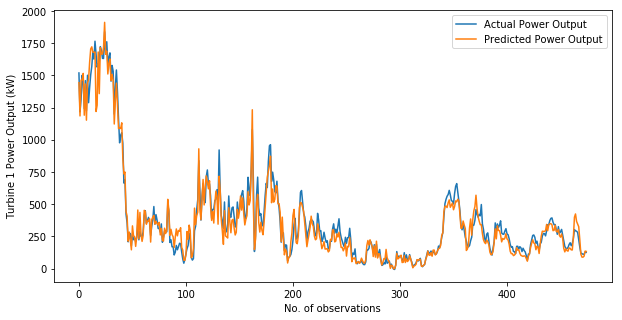

In [319]:
plt.figure(figsize=(10,5))
plt.plot(y_test[225:700], label='Actual Power Output')
plt.plot(y_predicted[225:700], label='Predicted Power Output')
plt.xlabel('No. of observations')
plt.ylabel('Turbine 1 Power Output (kW)')
plt.legend(loc='upper right')
plt.title('Next 72 hours Prediction for Turbine 1')

# Future Work and Resources

The future work on this project will consider the following directions:
 - Utiliznig multiple machine learning models and comparing the performance
 - Incorporating large scale weather data using Numerical Weather prediction models
 - Adopting a probabilistic forecasting approach 
 
Resources:<br>
[Random Forest in Python](https://towardsdatascience.com/random-forest-in-python-24d0893d51c0)<br>
[Mauch, B., Apt, J., Carvalho, P. M., & Jaramillo, P. (2013). What day-ahead reserves are needed in electric grids with high levels of wind power?](https://www.google.com/search?q=mauch+et+all+day+ahead+reserve&rlz=1C1GCEA_enUS782US782&oq=mauch+et+all+day+ahead+reserve+&aqs=chrome..69i57j69i59.3534j0j7&sourceid=chrome&ie=UTF-8)<br>
[Scikit-learn Documentation](http://scikit-learn.org/stable/documentation.html)<br>
[ENGIE web api documentation](https://opendata-renewables.engie.com/api/v1/documentation)<br>
[Wind Forecasting](https://www.iitk.ac.in/ime/anoops/for14/PPTs/Day%20-%202%20IITK/Wind%20Frorecasting-%20Balaraman.pdf)<br>
[Wind Power Forecasting](https://lucdemortier.github.io/articles/17/WindPower)<br>